# SimpleMLPipelinePoC_Ph01_TransformTest
- feed tf.Example into Transformer
- Decode(convert to tensor)
- Resize
- Rescale
- Data Augmentation(skip)
- check Artifact of Transformer

### write module file including preprocessing_fn

In [1]:

from typing import List, Text
from absl import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow_metadata.proto.v0 import schema_pb2
import tensorflow_transform as tft
from tensorflow_transform.tf_metadata import schema_utils
import tensorflow_hub as hub

from tfx import v1 as tfx
from tfx_bsl.public import tfxio

2024-10-09 11:00:12.288143: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 11:00:12.947824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 11:00:12.947919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 11:00:13.093854: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 11:00:13.390924: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 11:00:13.394629: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
_module_file = '/home/jupyter/SimpleMLPIpeline/uploadFromGitHub/PoC/preprocess_train_module_06_toServe.py'

In [3]:
%%writefile {_module_file}

from typing import List, Text
from absl import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow_metadata.proto.v0 import schema_pb2
import tensorflow_transform as tft
from tensorflow_transform.tf_metadata import schema_utils
import tensorflow_hub as hub

from tfx import v1 as tfx
from tfx_bsl.public import tfxio

# Specify features that we will use.
# Use the same key names as specified when rendering images into TFRecords.
_FEATURE_KEY = 'image_raw'
_LABEL_KEY = 'label'

_FEATURE_KEYS = ['image_raw',]

_TRAIN_BATCH_SIZE = 100
_EVAL_BATCH_SIZE = 10

_IMG_HEIGHT = 299
_IMG_WIDTH = 299

def preprocessing_fn(inputs):
    outputs = {}
    raw_image_dataset = tf.sparse.to_dense(inputs[_FEATURE_KEY])
    
    image_tensor = tf.map_fn(
        fn=lambda x : tf.image.resize(
            tf.io.decode_image(x[0], dtype=tf.float32, channels=3, expand_animations=False),
            [_IMG_HEIGHT, _IMG_WIDTH]),
        elems=raw_image_dataset,
        fn_output_signature=tf.TensorSpec((_IMG_HEIGHT, _IMG_WIDTH, 3), dtype=tf.float32, name=None),
        infer_shape = True)
    outputs[_FEATURE_KEY] = image_tensor

    label = tf.sparse.to_dense(inputs[_LABEL_KEY])
    # label = tf.reshape(label, [-1])
    # outputs[_LABEL_KEY] = label
    
    with tf.init_scope():
        table_keys = ['[0]','[1]','[2]','[3]','[4]','[5]','[6]','[7]','[8]','[9]']
        initializer = tf.lookup.KeyValueTensorInitializer(
            keys=table_keys,
            values=tf.cast(tf.range(len(table_keys)), tf.int64),
            key_dtype=tf.string,
            value_dtype=tf.int64)
        table = tf.lookup.StaticHashTable(initializer, default_value=-1)
    
    label = table.lookup(inputs[_LABEL_KEY])
    label = tf.sparse.to_dense(label)
    label = tf.reshape(label, [-1])
    
    outputs[_LABEL_KEY] = label
    
    return outputs

def _apply_preprocessing(raw_features, tft_layer):
  transformed_features = tft_layer(raw_features)
  if _LABEL_KEY in raw_features:
    transformed_label = transformed_features.pop(_LABEL_KEY)
    return transformed_features, transformed_label
  else:
    return transformed_features, None

def _get_serve_tf_examples_fn(model, tf_transform_output):
  model.tft_layer = tf_transform_output.transform_features_layer()

  @tf.function(input_signature=[
      tf.TensorSpec(shape=[None], dtype=tf.string, name='examples')
  ])
  def serve_tf_examples_fn(serialized_tf_examples):
    # Expected input is a string which is serialized tf.Example format.
    feature_spec = tf_transform_output.raw_feature_spec()
    # Because input schema includes unnecessary fields like 'species' and
    # 'island', we filter feature_spec to include required keys only.
    required_feature_spec = {
        k: v for k, v in feature_spec.items() if k in _FEATURE_KEYS
    }
    parsed_features = tf.io.parse_example(serialized_tf_examples,
                                          required_feature_spec)

    # Preprocess parsed input with transform operation defined in
    # preprocessing_fn().
    transformed_features, _ = _apply_preprocessing(parsed_features,
                                                   model.tft_layer)
    # Run inference with ML model.
    return model(transformed_features)

  return serve_tf_examples_fn


def _input_fn(file_pattern: List[Text],
              data_accessor: tfx.components.DataAccessor,
              tf_transform_output: tft.TFTransformOutput,
              batch_size: int = 100) -> tf.data.Dataset:
  """Generates features and label for tuning/training.

  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    tf_transform_output: A TFTransformOutput.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch

  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """
  dataset = data_accessor.tf_dataset_factory(
      file_pattern,
      tfxio.TensorFlowDatasetOptions(batch_size=batch_size),
      schema=tf_transform_output.raw_metadata.schema)

  transform_layer = tf_transform_output.transform_features_layer()
  def apply_transform(raw_features):
    return _apply_preprocessing(raw_features, transform_layer)

  return dataset.map(apply_transform).repeat()


def _freeze_model_by_percentage(model: tf.keras.Model, percentage: float):
  if percentage < 0 or percentage > 1:
    raise ValueError('Freeze percentage should between 0.0 and 1.0')

  if not model.trainable:
    raise ValueError(
        'The model is not trainable, please set model.trainable to True')

  num_layers = len(model.layers)
  num_layers_to_freeze = int(num_layers * percentage)
  for idx, layer in enumerate(model.layers):
    if idx < num_layers_to_freeze:
      layer.trainable = False
    else:
      layer.trainable = True

def _build_keras_model() -> tf.keras.Model:
  """Creates a DNN Keras model for classifying MNIST data.
  ここでTFHubからインポートしたCNN系モデルによるあれを作る。
  Returns:
    A Keras Model.
  """
  # The model below is built with Functional API, please refer to
  # https://www.tensorflow.org/guide/keras/overview for all API options.
  inputs = [
      keras.layers.Input(shape=(_IMG_HEIGHT, _IMG_WIDTH, 3), name=_FEATURE_KEY)
  ]

  inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

  feature_extractor_model = inception_v3

  feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(_IMG_HEIGHT, _IMG_WIDTH, 3),
    trainable=False
  )

  model = tf.keras.Sequential([
    keras.layers.Input(shape=(_IMG_HEIGHT, _IMG_WIDTH, 3), name=_FEATURE_KEY),
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10)
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(1e-2),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy()])

  model.summary(print_fn=logging.info)
  return model


# TFX Trainer will call this function.
def run_fn(fn_args: tfx.components.FnArgs):
  """Train the model based on given args.

  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """
  tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)

  train_dataset = _input_fn(
      fn_args.train_files,
      fn_args.data_accessor,
      tf_transform_output,
      batch_size=_TRAIN_BATCH_SIZE)
  eval_dataset = _input_fn(
      fn_args.eval_files,
      fn_args.data_accessor,
      tf_transform_output,
      batch_size=_EVAL_BATCH_SIZE)

  model = _build_keras_model()
  model.fit(
      train_dataset,
      steps_per_epoch=fn_args.train_steps,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps)

  # NEW: Save a computation graph including transform layer.
  signatures = {
      'serving_default': _get_serve_tf_examples_fn(model, tf_transform_output),
  }
  model.save(fn_args.serving_model_dir, save_format='tf', signatures=signatures)

Overwriting /home/jupyter/SimpleMLPIpeline/uploadFromGitHub/PoC/preprocess_train_module_06_toServe.py


### Try feeding preprocessing_fn a TFExample from previous PoC

In [126]:
tfrecord_path = '/var/tmp/tfx-interactive-2024-10-07T13_32_19.131107-lcrzhk_n/Transform/transformed_examples/4'
raw_dataset = tf.data.TFRecordDataset([f'{tfrecord_path}/Split-train/transformed_examples-00000-of-00001.gz'], compression_type='GZIP')
print(type(raw_dataset))

# for raw_record in raw_dataset.take(1):
#     example = tf.train.Example()
#     example.ParseFromString(raw_record.numpy())
#     print(example)

<class 'tensorflow.python.data.ops.readers.TFRecordDatasetV2'>


In [19]:
import numpy as np
np.set_printoptions(precision=3, suppress=False)

In [128]:
from tensorflow import train

_FEATURE_KEY = 'image_raw'
_LABEL_KEY = 'label'
# TFRecordの仕様に合わせた関数（パーサー）
def _parse_function(proto):
    # 特徴量の定義
    keys_to_features = {
        _FEATURE_KEY: tf.io.FixedLenFeature([], tf.string),  # bytes_listとして保存されているのでstringで読み込む
        _LABEL_KEY: tf.io.FixedLenFeature([], tf.string)  # labelもstringとして読み込む
    }
    
    # tf.train.Exampleから特徴量をパースする
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    return parsed_features

# テスト用のTFRecordファイルからデータを読み込み、解析する
parsed_dataset = raw_dataset.map(_parse_function)

# 先頭の1つの要素を取り出してテスト
for parsed_record in parsed_dataset.take(1):
    # preprocessing_fnに渡すためにinputs形式に変換する
    inputs = {
        _FEATURE_KEY: parsed_record[_FEATURE_KEY],
        _LABEL_KEY: parsed_record[_LABEL_KEY]
    }
    
    # preprocessing_fnを呼び出して出力を確認する
    outputs = preprocessing_fn(inputs)
    
    # 出力の確認
    print("Processed Image Tensor: ", outputs[_FEATURE_KEY].numpy())
    print("Processed Label Tensor: ", outputs[_LABEL_KEY].numpy())

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} /var/tmp/tfx-interactive-2024-10-07T13_32_19.131107-lcrzhk_n/Transform/transformed_examples/4/Split-train/data_tfrecord-00000-of-00001.gz; No such file or directory [Op:IteratorGetNext] name: 

0が多いが平均を見ると問題ないことがわかる。

In [35]:
outputs[_FEATURE_KEY].numpy().mean()

0.124867305

In [36]:
output = outputs[_FEATURE_KEY].numpy()
output.shape

(240, 180, 1)

In [37]:
import matplotlib.pyplot as plt

##### 縦に伸ばされているものの、問題ないテンソルが得られた。

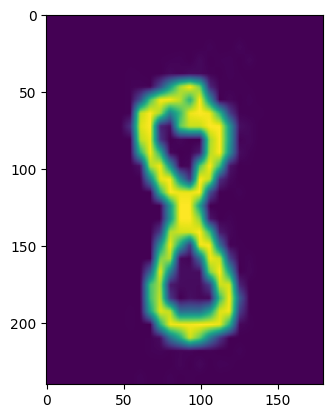

In [40]:
%matplotlib inline
plt.imshow(output)

### Try using code via Transformer
insert StatisticsGen and SchemaGen in between; it doesn't seem to take long to add them

In [4]:
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.components import ImportExampleGen, StatisticsGen, SchemaGen, Transform, Trainer
import os

#### ExampleGen

In [5]:
context = InteractiveContext()

input_base = '/home/jupyter/Poc/Ph01/'
example_gen = ImportExampleGen(input_base=input_base)

context.run(example_gen)

ExecutionResult(
    component_id: ImportExampleGen
    execution_id: 1
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=ImportExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

#### StatisticsGen

In [6]:
statistics_gen = StatisticsGen(examples=example_gen.outputs['examples'])
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [8]:
context.show(statistics_gen.outputs['statistics'])

#### SchemaGen

In [9]:
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=False)  # Transformでresizeするのでschemaには加えない
context.run(schema_gen)


ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [10]:
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'image_raw',BYTES,required,single,-
'label',STRING,required,single,'label'


,Values
Domain,
'label',"'[0]', '[1]', '[2]', '[3]', '[4]', '[5]', '[6]', '[7]', '[8]', '[9]'"


#### Transform

In [11]:
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=_module_file)
context.run(transform)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying preprocess_train_module_05_toServe.py -> build/lib
copying jpeg_to_tfrecord.py -> build/lib
copying preprocess_train_module_04_experiment.py -> build/lib
copying preprocess_train_module_06_toServe.py -> build/lib
copying preprocess_train_module_02.py -> build/lib
copying preprocess_train_module.py -> build/lib
copying preprocess_train_module_03.py -> build/lib
installing to /var/tmp/tmpok2aglh_
running install
running install_lib
copying build/lib/preprocess_train_module_03.py -> /var/tmp/tmpok2aglh_/.
copying build/lib/preprocess_train_module.py -> /var/tmp/tmpok2aglh_/.
copying build/lib/preprocess_train_module_05_toServe.py -> /var/tmp/tmpok2aglh_/.
copying build/lib/preprocess_train_module_02.py -> /var/tmp/tmpok2aglh_/.
copying build/lib/preprocess_train_module_04_experiment.py -> /var/tmp/tmpok2aglh_/.
copying build/lib/jpeg_to_tfrecord.py -> /var/tmp/tmpok2aglh_/.
copying build/lib/prepr

/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()


reading manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
Copying tfx_user_code_Transform.egg-info to /var/tmp/tmpok2aglh_/./tfx_user_code_Transform-0.0+78fd8680071c40548215f1823eba8351ebc8ebe1660288b798fefd74819eb0ac-py3.10.egg-info
running install_scripts
creating /var/tmp/tmpok2aglh_/tfx_user_code_Transform-0.0+78fd8680071c40548215f1823eba8351ebc8ebe1660288b798fefd74819eb0ac.dist-info/WHEEL
creating '/var/tmp/tmpxaevz68c/tfx_user_code_Transform-0.0+78fd8680071c40548215f1823eba8351ebc8ebe1660288b798fefd74819eb0ac-py3-none-any.whl' and adding '/var/tmp/tmpok2aglh_' to it
adding 'jpeg_to_tfrecord.py'
adding 'preprocess_train_module.py'
adding 'preprocess_train_module_02.py'
adding 'preprocess_train_module_03.py'
adding 'preprocess_train_module_04_experiment.py'
adding 'preprocess_train_module_05_toServe.py'
adding 'preprocess_train_module_06_toServe.py'
adding 'tfx_user_code_Transform-0.0+78fd8680071c405482

INFO:tensorflow:Assets written to: /var/tmp/tfx-interactive-2024-10-09T11_00_47.916406-zsni0htj/Transform/transform_graph/4/.temp_path/tftransform_tmp/1e15fc58e10b4d6db0214860bc50ae91/assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


ExecutionResult(
    component_id: Transform
    execution_id: 4
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

いったああああああああ

In [97]:
!ls '/var/tmp/tfx-interactive-2024-10-07T10_24_21.565352-oy0flqs7/Transform/transform_graph/23/.temp_path/tftransform_tmp/fbd636ab8633417dab7a28be3be68d12/assets'

ls: cannot access '/var/tmp/tfx-interactive-2024-10-07T10_24_21.565352-oy0flqs7/Transform/transform_graph/23/.temp_path/tftransform_tmp/fbd636ab8633417dab7a28be3be68d12/assets': No such file or directory


### Check transformed examples

In [19]:
transform.outputs

{'transform_graph': OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False),
 'transformed_examples': OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False),
 'updated_analyzer_cache': OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False),
 'pre_transform_schema': OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False),
 'pre_transform_stats': OutputChannel(artifact_type=ExampleStatistics, producer_componen

In [40]:
import os
train_uri = transform.outputs['transform_graph'].get()[0].uri
os.listdir(train_uri)

['transform_fn', 'metadata', 'transformed_metadata']

In [21]:
import pprint
pp = pprint.PrettyPrinter()

In [24]:
!ls {train_uri}

metadata  transform_fn	transformed_metadata


In [44]:
import tensorflow as tf
# Get the URI of the output artifact representing the transformed examples, which is a directory
train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Iterate over the first 3 records and decode them.
for tfrecord in dataset.take(1):
  serialized_example = tfrecord.numpy()
  example = tf.train.Example()
  example.ParseFromString(serialized_example)
  pp.pprint(example)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [45]:
type(example)

tensorflow.core.example.example_pb2.Example

In [125]:
!ls /var/tmp/tfx-interactive-2024-10-07T13_32_19.131107-lcrzhk_n/Transform/transformed_examples/4/Split-train

transformed_examples-00000-of-00001.gz


In [129]:
tfrecord_path = '/var/tmp/tfx-interactive-2024-10-07T13_32_19.131107-lcrzhk_n/Transform/transformed_examples/4'
raw_dataset = tf.data.TFRecordDataset([f'{tfrecord_path}/Split-train/transformed_examples-00000-of-00001.gz'], compression_type='GZIP')
print(type(raw_dataset))

# for raw_record in raw_dataset.take(1):
#     example = tf.train.Example()
#     example.ParseFromString(raw_record.numpy())
#     print(example)

<class 'tensorflow.python.data.ops.readers.TFRecordDatasetV2'>


### Restart the pipeline from Trainer

In [ ]:
trainer = Trainer(
    module_file=os.path.abspath(_module_file),
    # examples=transform.outputs['transformed_examples'],
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    transform_graph=transform.outputs['transform_graph'],
    train_args=tfx.proto.TrainArgs(num_steps=100),
    eval_args=tfx.proto.EvalArgs(num_steps=5))
context.run(trainer)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying preprocess_train_module_05_toServe.py -> build/lib
copying jpeg_to_tfrecord.py -> build/lib
copying preprocess_train_module_04_experiment.py -> build/lib
copying preprocess_train_module_06_toServe.py -> build/lib
copying preprocess_train_module_02.py -> build/lib
copying preprocess_train_module.py -> build/lib
copying preprocess_train_module_03.py -> build/lib
installing to /var/tmp/tmpr1d_ualh
running install
running install_lib
copying build/lib/preprocess_train_module_03.py -> /var/tmp/tmpr1d_ualh/.
copying build/lib/preprocess_train_module.py -> /var/tmp/tmpr1d_ualh/.
copying build/lib/preprocess_train_module_05_toServe.py -> /var/tmp/tmpr1d_ualh/.
copying build/lib/preprocess_train_module_02.py -> /var/tmp/tmpr1d_ualh/.
copying build/lib/preprocess_train_module_04_experiment.py -> /var/tmp/tmpr1d_ualh/.
copying build/lib/jpeg_to_tfrecord.py -> /var/tmp/tmpr1d_ualh/.
copying build/lib/prepr

/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()


reading manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
Copying tfx_user_code_Trainer.egg-info to /var/tmp/tmpr1d_ualh/./tfx_user_code_Trainer-0.0+78fd8680071c40548215f1823eba8351ebc8ebe1660288b798fefd74819eb0ac-py3.10.egg-info
running install_scripts
creating /var/tmp/tmpr1d_ualh/tfx_user_code_Trainer-0.0+78fd8680071c40548215f1823eba8351ebc8ebe1660288b798fefd74819eb0ac.dist-info/WHEEL
creating '/var/tmp/tmpccapgdoe/tfx_user_code_Trainer-0.0+78fd8680071c40548215f1823eba8351ebc8ebe1660288b798fefd74819eb0ac-py3-none-any.whl' and adding '/var/tmp/tmpr1d_ualh' to it
adding 'jpeg_to_tfrecord.py'
adding 'preprocess_train_module.py'
adding 'preprocess_train_module_02.py'
adding 'preprocess_train_module_03.py'
adding 'preprocess_train_module_04_experiment.py'
adding 'preprocess_train_module_05_toServe.py'
adding 'preprocess_train_module_06_toServe.py'
adding 'tfx_user_code_Trainer-0.0+78fd8680071c40548215f1823eba8351

Instructions for updating:
Use `tf.data.Dataset.map(tf.io.parse_example(...))` instead.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


100/100 [==============================] - 1128s 11s/step - loss: 0.6940 - sparse_categorical_accuracy: 0.8388 - val_loss: 0.1601 - val_sparse_categorical_accuracy: 0.9600
INFO:tensorflow:Assets written to: /var/tmp/tfx-interactive-2024-10-09T11_00_47.916406-zsni0htj/Trainer/model/5/Format-Serving/assets


INFO:tensorflow:Assets written to: /var/tmp/tfx-interactive-2024-10-09T11_00_47.916406-zsni0htj/Trainer/model/5/Format-Serving/assets


ExecutionResult(
    component_id: Trainer
    execution_id: 5
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Trainer, output_key=model, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        model_run: OutputChannel(artifact_type=ModelRun, producer_component_id=Trainer, output_key=model_run, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [13]:
# Get the URI of the output artifact representing the training logs, which is a directory
model_run_dir = trainer.outputs['model_run'].get()[0].uri

%load_ext tensorboard
%tensorboard --logdir {model_run_dir}

In [14]:
_serving_model_dir = '/home/jupyter/Poc/Ph01/model'

#### just test Pusher

In [18]:
from tfx.components import Pusher
pusher = Pusher(
    model=trainer.outputs['model'],
    push_destination=tfx.proto.PushDestination(
        filesystem=tfx.proto.PushDestination.Filesystem(
            base_directory=_serving_model_dir)))
context.run(pusher)

ExecutionResult(
    component_id: Pusher
    execution_id: 6
    outputs:
        pushed_model: OutputChannel(artifact_type=PushedModel, producer_component_id=Pusher, output_key=pushed_model, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [20]:
push_uri = pusher.outputs['pushed_model'].get()[0].uri
model = tf.saved_model.load(push_uri)

for item in model.signatures.items():
    print(item)

('serving_default', <ConcreteFunction (*, examples: TensorSpec(shape=(None,), dtype=tf.string, name='examples')) -> Dict[['output_0', TensorSpec(shape=(None, 10), dtype=tf.float32, name='output_0')]] at 0x7F1CBFA75450>)


### Push model into Vertex AI Predictions

In [21]:
GOOGLE_CLOUD_PROJECT = 'mlpipelineportfolio'         # <--- ENTER THIS
# GOOGLE_CLOUD_PROJECT_NUMBER = '564758604505'  # <--- ENTER THIS
GOOGLE_CLOUD_REGION = 'asia-northeast1'          # <--- ENTER THIS
GCS_BUCKET_NAME = 'mlpipelineportfolio_bucket_01'              # <--- ENTER THIS

if not (GOOGLE_CLOUD_PROJECT and GOOGLE_CLOUD_REGION and GCS_BUCKET_NAME):
    from absl import logging
    logging.error('Please set all required parameters.')

In [22]:
# PIPELINE_NAME = 'penguin-vertex-training'

# Path to various pipeline artifact.
# PIPELINE_ROOT = 'gs://{}/pipeline_root/{}'.format(GCS_BUCKET_NAME, PIPELINE_NAME)

# Paths for users' Python module.
# MODULE_ROOT = 'gs://{}/pipeline_module/{}'.format(GCS_BUCKET_NAME, PIPELINE_NAME)

# Paths for users' data.
# DATA_ROOT = 'gs://{}/data/{}'.format(GCS_BUCKET_NAME, PIPELINE_NAME)

# Name of Vertex AI Endpoint.
ENDPOINT_NAME = 'prediction-PoCPh01'

# print('PIPELINE_ROOT: {}'.format(PIPELINE_ROOT))

In [25]:
# NEW: Configuration for pusher.
vertex_serving_spec = {
  'project_id': GOOGLE_CLOUD_PROJECT,
  'endpoint_name': ENDPOINT_NAME,
  # Remaining argument is passed to aiplatform.Model.deploy()
  # See https://cloud.google.com/vertex-ai/docs/predictions/deploy-model-api#deploy_the_model
  # for the detail.
  #
  # Machine type is the compute resource to serve prediction requests.
  # See https://cloud.google.com/vertex-ai/docs/predictions/configure-compute#machine-types
  # for available machine types and accelerators.
  'machine_type': 'n1-standard-4',
}

# Vertex AI provides pre-built containers with various configurations for
# serving.
# See https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
# for available container images.
serving_image = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-6:latest'
# if use_gpu:
#     vertex_serving_spec.update({
#         'accelerator_type': 'NVIDIA_TESLA_K80',
#         'accelerator_count': 1
#     })
# serving_image = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-gpu.2-6:latest'

# NEW: Pushes the model to Vertex AI.
pusher = tfx.extensions.google_cloud_ai_platform.Pusher(
  model=trainer.outputs['model'],
  custom_config={
      tfx.extensions.google_cloud_ai_platform.ENABLE_VERTEX_KEY:
          True,
      tfx.extensions.google_cloud_ai_platform.VERTEX_REGION_KEY:
          GOOGLE_CLOUD_REGION,
      tfx.extensions.google_cloud_ai_platform.VERTEX_CONTAINER_IMAGE_URI_KEY:
          serving_image,
      tfx.extensions.google_cloud_ai_platform.SERVING_ARGS_KEY:
        vertex_serving_spec,
  })

In [26]:
context.run(pusher)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/564758604505/locations/asia-northeast1/endpoints/6048866463186419712/operations/7366930765994524672
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/564758604505/locations/asia-northeast1/endpoints/6048866463186419712
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/564758604505/locations/asia-northeast1/endpoints/6048866463186419712')
INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/564758604505/locations/asia-northeast1/models/6640267379488063488/operations/992648443405008896
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/564758604505/locations/asia-northeast1/models/6640267379488063488@1
INFO:google.cloud.aiplatform.models:To 

ExecutionResult(
    component_id: Pusher
    execution_id: 7
    outputs:
        pushed_model: OutputChannel(artifact_type=PushedModel, producer_component_id=Pusher, output_key=pushed_model, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

#### Check deployed model

In [40]:
from google.cloud import aiplatform
from google.cloud import aiplatform_v1 as aiplatform_v1
from google.cloud.aiplatform.gapic import PredictionServiceClient
from google.cloud.aiplatform.gapic.schema import predict
import base64

##### 今回のmodelはpredict_schemaが設定できていない。

In [48]:
def get_model_sample(
    project: str,
    model_id: str,
    location: str = "asia-northeast1",
    api_endpoint: str = "asia-northeast1-aiplatform.googleapis.com",
):
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.ModelServiceClient(client_options=client_options)
    name = client.model_path(project=project, location=location, model=model_id)
    response = client.get_model(name=name)
    return response
    
model = get_model_sample(project='mlpipelineportfolio',
                 model_id='6640267379488063488')
model

name: "projects/564758604505/locations/asia-northeast1/models/6640267379488063488"
display_name: "v1728477395"
predict_schemata {
}
metadata {
}
container_spec {
  image_uri: "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-6:latest"
}
supported_deployment_resources_types: DEDICATED_RESOURCES
supported_deployment_resources_types: SHARED_RESOURCES
supported_input_storage_formats: "jsonl"
supported_input_storage_formats: "bigquery"
supported_input_storage_formats: "csv"
supported_input_storage_formats: "tf-record"
supported_input_storage_formats: "tf-record-gzip"
supported_input_storage_formats: "file-list"
supported_output_storage_formats: "jsonl"
supported_output_storage_formats: "bigquery"
create_time {
  seconds: 1728477402
  nanos: 111613000
}
update_time {
  seconds: 1728477407
  nanos: 344885000
}
deployed_models {
  endpoint: "projects/564758604505/locations/asia-northeast1/endpoints/6048866463186419712"
  deployed_model_id: "9216181230809120768"
}
etag: "AMEw9yPHzfCV7Llfcrm2nC-

##### チュートリアルのモデルはどうか？

In [49]:
model = get_model_sample(project='mlpipelineportfolio',
                 model_id='631902526622400512')
model

name: "projects/564758604505/locations/asia-northeast1/models/631902526622400512"
display_name: "v1727719832"
predict_schemata {
}
metadata {
}
container_spec {
  image_uri: "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-6:latest"
}
supported_deployment_resources_types: DEDICATED_RESOURCES
supported_deployment_resources_types: SHARED_RESOURCES
supported_input_storage_formats: "jsonl"
supported_input_storage_formats: "bigquery"
supported_input_storage_formats: "csv"
supported_input_storage_formats: "tf-record"
supported_input_storage_formats: "tf-record-gzip"
supported_input_storage_formats: "file-list"
supported_output_storage_formats: "jsonl"
supported_output_storage_formats: "bigquery"
create_time {
  seconds: 1727720028
  nanos: 965476000
}
update_time {
  seconds: 1727720034
  nanos: 353985000
}
etag: "AMEw9yPeJlVJUMOkw6I_8tiL-WPpUILC6IXvaZudQCXdcOl7bEEIbYK7Meq0xH869KQu"
supported_export_formats {
  id: "custom-trained"
  exportable_contents: ARTIFACT
}
artifact_uri: "gs://mlpip

#### Try sending request

In [27]:
ENDPOINT_ID='6048866463186419712'     # <--- ENTER THIS
if not ENDPOINT_ID:
    from absl import logging
    logging.error('Please set the endpoint id.')

In [32]:
client_options = {
    'api_endpoint': GOOGLE_CLOUD_REGION + '-aiplatform.googleapis.com'
    }
# Initialize client that will be used to create and send requests.
client = PredictionServiceClient(client_options=client_options)

In [110]:
# JPEG画像を読み込んでbase64にエンコードする
def encode_image(image_path):
    img = tf.io.read_file(image_path)
    img_encoded = base64.b64encode(img.numpy()).decode("utf-8")
    return img_encoded

# 推論する画像のパス
image_path = '/home/jupyter/Poc/dataset/cifar10_images_subsampled_01/[0]/mnist_115.jpg'

# リクエスト用の画像データのエンコード
encoded_image = encode_image(image_path)

# インスタンスを作成。'examples' キーにエンコードしたJPEG画像を渡す。
# instances = [{
#     'examples':encoded_image
# }]

instances = [{
    'exames': tf.io.read_file(image_path)
}]

endpoint = client.endpoint_path(
    project=GOOGLE_CLOUD_PROJECT,
    location=GOOGLE_CLOUD_REGION,
    endpoint=ENDPOINT_ID,
)

# Send a prediction request and get response.
response = client.predict(endpoint=endpoint, instances=instances)

# Uses argmax to find the index of the maximum value.
print('species:', np.argmax(response.predictions[0]))


ValueError: Unable to coerce value: <tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00 \x00 \x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\xd4\xd5\xd6\xd7\xd8\xd9\xda\xe1\xe2\xe3\xe4\xe5\xe6\xe7\xe8\xe9\xea\xf1\xf2\xf3\xf4\xf5\xf6\xf7\xf8\xf9\xfa\xff\xc4\x00\x1f\x01\x00\x03\x01\x01\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x11\x00\x02\x01\x02\x04\x04\x03\x04\x07\x05\x04\x04\x00\x01\x02w\x00\x01\x02\x03\x11\x04\x05!1\x06\x12AQ\x07aq\x13"2\x81\x08\x14B\x91\xa1\xb1\xc1\t#3R\xf0\x15br\xd1\n\x16$4\xe1%\xf1\x17\x18\x19\x1a&\'()*56789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x82\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\xd4\xd5\xd6\xd7\xd8\xd9\xda\xe2\xe3\xe4\xe5\xe6\xe7\xe8\xe9\xea\xf2\xf3\xf4\xf5\xf6\xf7\xf8\xf9\xfa\xff\xda\x00\x0c\x03\x01\x00\x02\x11\x03\x11\x00?\x00\xfd\x8f\xd5<=9\x90\xcb!\x04\x81\x80q\xcdb^h3\x197\xc6{\x9c\x9c\xd7+\xfbf~\xd9\x1f\x07?c\xcd\x07\xc3\xde\'\xf8\xcd\xe2\xd8t=/]\xf1\x1aX\x1dF\xe2\'d\x8cmg|\x84\x04\xe7h\xe3\x8e\xb5\xe47\x9f\xf0Y\xef\xf8%\xfd\x9c\xc2=O\xf6\xbc\xf0\xed\x8b0\xdc\xa9\x7fmu\x0b`\xf7\xc3B(\x03\xe8e\xd0n\xf6rz\x9e\xe6\xaeZhW\x92 \x0c2\x07\x03\x06\xbe]\xf0\xef\xfc\x16\xf7\xfe\t\x87\xe2\x1f\x19Zx4~\xd4\xba=\x93\xea\x03u\x8e\xa7\xa8#\xc5c0\xdc\xcb\xcc\xe4m\x8c\xe4t}\xa7\x04\x1a\xed\x7fd\x9f\xdb{J\xfd\xa5\x7fm\xdf\x89\xdf\xb3\xd7\x82\xfcm\xe1\ro\xc3~\x14\xd1m.t+\xad\n\xfb\xce\xbbiW`\xbai\x19X\xa4\x91\x132le\xe9\xb4\x83\x9c\xd0\x075\xff\x00\x05Y\xfd\x8a\xf4?\xf8(w\xc1\xcb\x0f\x87\x9ao\x8e\xed\xfc5\xaehz\x8b\xea:\x1f\x88%\x84\xbf\xd9\xa6\xda\x17k\x01\xce\xc6\xcf \x7ft\x1e\xd5\xf8\x1b\xff\x00\x05\r\xff\x00\x82q\xfe\xd9\xbf\x02>1\xdcA\xf1GU\xf1/\xc4/2\xc2/\xb3\xf8\x9b@\xf0\xd5\xd5\xc5\xb4\xd8E\n\xaa\xd1\x82\xa4\x8f\x99H;Xm\xc9\xcek\xf5+\xe2\x1f\xed\xbb\xe3\x1bmBw7WD\x1f\xba\xa6R\x00\xaf,\xd6\x7fn\x8f\x88H\xd3,Z\x8d\xe2!_\x98\xa5\xd61\xfa\xd0\x07\xcb\x9f\xb0G\xfc\x1b\xf1\xe3\xdf\xdb3\xc1\xb6\xbf\x14\xfe1~\xd1\xc7\xc0\xbe\x1f\xf9\xad\xa4\xd2u\x0f\t]G\xab\xa9\x1c\xaa\xc7\x15\xd0\x8e/,\xe7;\xd4\xb0\xe4\x8e\r~\x9c~\xc2?\xf0C\x7f\xd8C\xf6,\xf1\xd6\x97\xf1.\x7f\x8b\x9e2\xf1\x8e\xbb\xa5*\xacq\xde\xeaq\xd8XN\xa0c\xcb\x9a\xde\xd8\x0f><\x80v;\x10H\x04\xe6\xbe@?\xb6\xf7\xc4\xbdH\x86mz\xf5\x95_\xe5\xddp}~\xb5r\xd7\xf6\xd0\xf8\xad+\x89\x8e\xb9r\xa0I\xca\xbc\xccp?:\x00\xff\xd9'>

In [111]:
# Prepare an example and run inference.
features = {
  'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.read_file(image_path).numpy()])),
  }
example_proto = tf.train.Example(features=tf.train.Features(feature=features))
examples = example_proto.SerializeToString()

In [118]:
instances = [{
    'b64': base64.b64encode(examples).decode()
}]

response = client.predict(endpoint=endpoint, instances=instances)
response

predictions {
  list_value {
    values {
      number_value: 10.8460951
    }
    values {
      number_value: 4.43718863
    }
    values {
      number_value: 1.80950236
    }
    values {
      number_value: 0.0417313427
    }
    values {
      number_value: 2.58185816
    }
    values {
      number_value: 1.69211614
    }
    values {
      number_value: 0.250101745
    }
    values {
      number_value: 3.27530813
    }
    values {
      number_value: 5.10989761
    }
    values {
      number_value: 5.83301115
    }
  }
}
deployed_model_id: "9216181230809120768"
model: "projects/564758604505/locations/asia-northeast1/models/6640267379488063488"
model_display_name: "v1728477395"
model_version_id: "1"

In [76]:
import tensorflow as tf
from tensorflow.python.tools import saved_model_cli

# モデルのディレクトリを指定する (例えば、GCS バケットのパス)
model_dir = '/home/jupyter/Poc/Ph01/model/1728475363'

loaded_model = tf.saved_model.load(model_dir)

signature_keys = list(loaded_model.signatures.keys())
print("Available Signatures:", signature_keys)

# 'serving_default' の signature を取得
serving_signature = loaded_model.signatures['serving_default']

# SignatureDef の詳細を確認する
print(serving_signature.structured_input_signature)
print(serving_signature.structured_outputs)

Available Signatures: ['serving_default']
((), {'examples': TensorSpec(shape=(None,), dtype=tf.string, name='examples')})
{'output_0': TensorSpec(shape=(None, 10), dtype=tf.float32, name='output_0')}


In [78]:
inference_fn = loaded_model.signatures['serving_default']
inference_fn

<ConcreteFunction (*, examples: TensorSpec(shape=(None,), dtype=tf.string, name='examples')) -> Dict[['output_0', TensorSpec(shape=(None, 10), dtype=tf.float32, name='output_0')]] at 0x7F1CA2BC2B90>

In [79]:
# Prepare an example and run inference.
features = {
  'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.read_file(image_path).numpy()])),
  }
example_proto = tf.train.Example(features=tf.train.Features(feature=features))
examples = example_proto.SerializeToString()

result = inference_fn(examples=tf.constant([examples]))

In [80]:
result

{'output_0': <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[10.846096  ,  4.437187  ,  1.8095024 ,  0.04173126,  2.5818582 ,
          1.6921169 ,  0.25010067,  3.2753067 ,  5.1098957 ,  5.833012  ]],
       dtype=float32)>}

In [82]:
import numpy as np

softmax_result = tf.nn.softmax(result['output_0'])
print(softmax_result.numpy())
print(np.argmax(softmax_result.numpy()))

[[9.8758882e-01 1.6263814e-03 1.1749882e-04 2.0058571e-05 2.5436835e-04
  1.0448489e-04 2.4705523e-05 5.0889031e-04 3.1869556e-03 6.5678232e-03]]
0


###### 正しい推論ができてるっぽい

In [83]:
image_path = '/home/jupyter/Poc/dataset/cifar10_images_subsampled_01/[3]/mnist_101.jpg'

In [84]:
# Prepare an example and run inference.
features = {
  'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.read_file(image_path).numpy()])),
  }
example_proto = tf.train.Example(features=tf.train.Features(feature=features))
examples = example_proto.SerializeToString()

result = inference_fn(examples=tf.constant([examples]))
softmax_result = tf.nn.softmax(result['output_0'])
print(softmax_result.numpy())
print(np.argmax(softmax_result.numpy()))

[[3.2319974e-06 2.0156323e-05 7.3470115e-03 9.4777566e-01 3.9146780e-05
  4.3663211e-02 1.0837085e-03 6.4102431e-05 2.6527764e-06 1.1618514e-06]]
3


###### やはり行けてますね。

#### 以下のチュートリアルを参照してもう一度オンライン予測を送ってみる
https://cloud.google.com/vertex-ai/docs/predictions/get-online-predictions?hl=ja#online_predict_custom_trained-python_vertex_ai_sdk

In [95]:
def endpoint_predict_sample(
    project: str, location: str, instances: list, endpoint: str
):
    aiplatform.init(project=project, location=location)

    endpoint = aiplatform.Endpoint(endpoint)

    prediction = endpoint.predict(instances=instances)
    print(prediction)
    return prediction

In [104]:
features = {
  'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(
      value=[
          tf.io.read_file(image_path).numpy()
      ])),
  }

# features = {
#   'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b'ASa8asdf'])),
#   }

example_proto = tf.train.Example(features=tf.train.Features(feature=features))
examples = example_proto.SerializeToString()
examples = base64.b64encode(examples).decode()

# instances = [{
#     'examples': examples
# }]

instances = [
    {
        'examples': {
            'b64': examples
        }
    }
]

endpoint_predict_sample(project='mlpipelineportfolio',
                        location=GOOGLE_CLOUD_REGION,
                        instances=instances,
                        endpoint=ENDPOINT_ID)

Prediction(predictions=[[-1.24775195, 0.582662702, 6.48119879, 11.3410215, 1.2464664, 8.26340771, 4.56729364, 1.73963201, -1.44524527, -2.27083826]], deployed_model_id='9216181230809120768', metadata=None, model_version_id='1', model_resource_name='projects/564758604505/locations/asia-northeast1/models/6640267379488063488', explanations=None)


Prediction(predictions=[[-1.24775195, 0.582662702, 6.48119879, 11.3410215, 1.2464664, 8.26340771, 4.56729364, 1.73963201, -1.44524527, -2.27083826]], deployed_model_id='9216181230809120768', metadata=None, model_version_id='1', model_resource_name='projects/564758604505/locations/asia-northeast1/models/6640267379488063488', explanations=None)

は？なんか行けたんだが？？？？？訳がわからない？？？？
下だとどうなのか。これは無理だよな。うん。流石に。
```python
instances = [{
    'examples': examples
}]

predict = endpoint_predict_sample(project='mlpipelineportfolio',
                        location=GOOGLE_CLOUD_REGION,
                        instances=instances,
                        endpoint=ENDPOINT_ID)
```
やはりb64指定が必要だったと・・・
あと、バイナリの画像をbase64エンコードしろ、と言うのは、
今回tf.train.ExampleをSerializeToStringして、その戻り値をbase64エンコードしたように、バイナリデータそのもんではなくて最上層のjsonオブジェクトをエンコードして、それに'b64'というキーをつければいいということなんですね。へぇー。酷すぎないか、チュートリアルの書き方。
↑そもそもSerializeToStringの戻り値はバイナリデータだったらしい。すいません。

In [109]:
instances = [
    {
        'b64': examples
    }
]

endpoint_predict_sample(project='mlpipelineportfolio',
                        location=GOOGLE_CLOUD_REGION,
                        instances=instances,
                        endpoint=ENDPOINT_ID)

Prediction(predictions=[[-1.24775195, 0.582662702, 6.48119879, 11.3410215, 1.2464664, 8.26340771, 4.56729364, 1.73963201, -1.44524527, -2.27083826]], deployed_model_id='9216181230809120768', metadata=None, model_version_id='1', model_resource_name='projects/564758604505/locations/asia-northeast1/models/6640267379488063488', explanations=None)


Prediction(predictions=[[-1.24775195, 0.582662702, 6.48119879, 11.3410215, 1.2464664, 8.26340771, 4.56729364, 1.73963201, -1.44524527, -2.27083826]], deployed_model_id='9216181230809120768', metadata=None, model_version_id='1', model_resource_name='projects/564758604505/locations/asia-northeast1/models/6640267379488063488', explanations=None)

いや、これでも行けちゃうのかよ。そんなあ。name='examples'の指定は何だったんだ？？？

PredictionServiceClientの方でも,b64encodeしたTFExampleを'b64'で渡したらエラーなくいけた。結局、name='examples'の指定はPrediction側の計算グラフで入力テンソルを処理するときに利用する名前で、リクエスト側のキーを指定するものではなかったらしい。いや、にしてもな。PredictionServiceClient側で’b64'でも'examples'でもない名前にすると↓のエラーを出すのがミスリーディングすぎる。
```
InvalidArgument: 400 {
    "error": "Failed to process element: 0 key: wrong_name of 'instances' list. Error: Invalid argument: JSON object: does not have named input: wrong_name"
```

#### 複数のjpegからなるExamplesを送ってみる。

In [129]:
image_path_00 = '/home/jupyter/Poc/dataset/cifar10_images_subsampled_01/[0]/mnist_115.jpg'
image_path_06 = '/home/jupyter/Poc/dataset/cifar10_images_subsampled_01/[6]/mnist_125.jpg'
image_path_08 = '/home/jupyter/Poc/dataset/cifar10_images_subsampled_01/[8]/mnist_193.jpg'

In [125]:
features = {
  'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(
      value=[
          tf.io.read_file(image_path_05).numpy(),
          tf.io.read_file(image_path_05).numpy(),
          tf.io.read_file(image_path_08).numpy()
      ])),
  }

example_proto = tf.train.Example(features=tf.train.Features(feature=features))
examples = example_proto.SerializeToString()
examples = base64.b64encode(examples).decode()

instances = [
    {
        'examples': {
            'b64': examples
        }
    }
]

endpoint_predict_sample(project='mlpipelineportfolio',
                        location=GOOGLE_CLOUD_REGION,
                        instances=instances,
                        endpoint=ENDPOINT_ID)

Prediction(predictions=[[0.734102964, 2.56838894, 4.59341383, 9.15173626, 3.36835361, 9.10089779, 5.57719183, 5.40871239, -2.61850142, -3.149755]], deployed_model_id='9216181230809120768', metadata=None, model_version_id='1', model_resource_name='projects/564758604505/locations/asia-northeast1/models/6640267379488063488', explanations=None)


Prediction(predictions=[[0.734102964, 2.56838894, 4.59341383, 9.15173626, 3.36835361, 9.10089779, 5.57719183, 5.40871239, -2.61850142, -3.149755]], deployed_model_id='9216181230809120768', metadata=None, model_version_id='1', model_resource_name='projects/564758604505/locations/asia-northeast1/models/6640267379488063488', explanations=None)

先頭のやつしか処理してくれねえぞ。

In [131]:
def create_example(image_path):
    features = {
        'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(
            value=[
                tf.io.read_file(image_path).numpy()
            ])),
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=features))
    examples = example_proto.SerializeToString()
    return base64.b64encode(examples).decode()

instances = [
    {
        'b64': create_example(image_path_00),
    },
    {
        'b64': create_example(image_path_06),
    },
    {
        'b64': create_example(image_path_08)
    }
]

result = endpoint_predict_sample(project='mlpipelineportfolio',
                        location=GOOGLE_CLOUD_REGION,
                        instances=instances,
                        endpoint=ENDPOINT_ID)

Prediction(predictions=[[10.846097, 4.43718719, 1.80950189, 0.0417303294, 2.58185816, 1.69211674, 0.25010106, 3.27530861, 5.10989904, 5.83301067], [1.53300452, 0.504667163, 0.923500955, 8.00899887, 4.63453436, 2.31461072, 10.4378529, -1.35574627, 0.768311441, 1.7284435], [2.64041042, 2.51560163, 1.79197931, -0.607015491, 3.43482351, 1.46031713, 3.09630585, 2.06077743, 10.7784319, 5.0267005]], deployed_model_id='9216181230809120768', metadata=None, model_version_id='1', model_resource_name='projects/564758604505/locations/asia-northeast1/models/6640267379488063488', explanations=None)


これで行けたようです。

In [139]:
for pred in result.predictions:
    print(np.argmax(pred))
    print(tf.nn.softmax(pred)[np.argmax(pred)])

0
tf.Tensor(0.9875888, shape=(), dtype=float32)
6
tf.Tensor(0.9157965, shape=(), dtype=float32)
8
tf.Tensor(0.9948021, shape=(), dtype=float32)


なんとか当てたようです。

yosshaaaaaaaaa